#Лабораторная работа

Лабораторная работа №1 по линейной алгебре и обработке данных\
Работу выполнили студенты:\
J3112 - Морозов Дмитрий Александрович ИСУ: 466761\
J3112 - Фёдоров Егор Павлович ИСУ: 467866

#Теоретическая часть

#Практическая часть

##Создание класса матриц

Для выполнения лабораторной работы был реализован класс для хранения матриц. Объект класса хранит в себе матрицу в виде двумерного массива, а также размеры матрицы m на n.\
Были написаны функции для сложения, умножения (на скаляр и другую матрицу) и транспонирования матриц

In [107]:
import typing as tp
from typing import List, Tuple
import math


class Matrix:
    def __init__(self, matrix, m, n):
        self.matrix = matrix
        self.m = m
        self.n = n


def scalar_mult(A, alpha):
    new_matrix = [[alpha * A.matrix[i][j] for j in range(A.n)]for i in range(A.m)]
    return Matrix(new_matrix, A.m, A.n)

def additive(A, B):
    if A.m == B.m and A.n == B.n:
        new_matrix = [[B.matrix[i][j] + A.matrix[i][j] for j in range(A.n)] for i in range(A.m)]
        return Matrix(new_matrix, A.m, A.n)
    return None

def T(A):
    new_matrix = [[A.matrix[j][i] for j in range(A.m)] for i in range(A.n)]
    return Matrix(new_matrix, A.n, A.m)

def multiplicative(A, B):
    if A.n == B.m:
        result_matrix = []
        for i in range(A.m):
            current_row = []
            for j in range(B.n):
                current_element = 0
                for g in range(A.n):
                    current_element += A.matrix[i][g] * B.matrix[g][j]
                current_row.append(current_element)
            result_matrix.append(current_row)  # Добавляем строку после обработки всех столбцов
        return Matrix(result_matrix, A.m, B.n)
    return None


##Easy level


###Метод Гаусса

Метод Гаусса — метод для решения системы линейных уравнений $Ax=b$\
Алгорит делится на два этапа:
Прямой ход (приведение к верхнетреугольному виду), где мы
последовательно «зануляем» элементы под главной диагональю, используя элементарные операции над строками:
Выбираем в текущем столбце ненулевой (оптимально — максимальный по модулю) пивот;
Делим строку-«маятник» на значение пивота, чтобы на диагонали были 1;
Вычитаем из каждой нижележащей строки нормированную строку, обнуляя поддиагональные элементы.
Получив ступенчатую матрицу делаем обратную подстановку:\
Начинаем с последнего уравнения (где только одна невырожденная переменная) и поочерёдно выражаем каждую
$x_n = \frac{b_n}{A_{nn}}, x_i = \frac{b_i - \sum_{j=i+1}^{n} A_{ij} \cdot x_j}{A_{ii}}
$


In [108]:
def gauss_solver(A:'Matrix', b:'Matrix') -> List['Matrix']:
    """
    Вход:
    A: матрица коэффициентов (n×n). Используется класс Matrix из предыдущей
    лабораторной работы→
    b: вектор правых частей (n×1)
    Выход:
    Raises:
    list[Matrix]: список базисных векторов решения системы
    ValueError: если система несовместна
    """


    m = A.m
    n = A.n

    tol = 1e-6
    m, n = A.m, A.n
    # строим расширенную
    ext = [A.matrix[i] + [b.matrix[i][0]] for i in range(m)]
    # 1) динамический порог
    max_mod = 0.0
    for i in range(m):
        for j in range(n + 1):
            max_mod = max(max_mod, abs(ext[i][j]))
    eps = tol * max(1.0, max_mod)


    pivots = []
    row = 0
    for col in range(n):
        for r in range(row, m):
            if abs(ext[r][col]) > eps:
                ext[row], ext[r] = ext[r], ext[row]
                break
        else:
            continue

        pivot_val = ext[row][col]
        for j in range(col, n + 1):
            ext[row][j] /= pivot_val

        for i in range(row + 1, m):
            coeff = ext[i][col]
            for j in range(col, n + 1):
                ext[i][j] -= coeff * ext[row][j]

        pivots.append(col)
        row += 1

    for i in range(row, m):
        if all(abs(ext[i][j]) < eps for j in range(n)) and abs(ext[i][n]) > eps:
            raise ValueError("Система несовместна")

    free = [j for j in range(n) if j not in pivots]
    x0 = [0.0] * n


    for i in reversed(range(len(pivots))):
        col = pivots[i]
        val = ext[i][n]
        for j in range(col + 1, n):
            val -= ext[i][j] * x0[j]
        x0[col] = val

    sol = []
    part = [[x0[i]] for i in range(n)]
    sol.append(Matrix(part, n, 1))

    for fr in free:
        vec = [0.0] * n
        vec[fr] = 1.0
        for i in reversed(range(len(pivots))):
            col = pivots[i]
            val = 0.0
            for j in range(col + 1, n):
                val -= ext[i][j] * vec[j]
            vec[col] = val
        sol.append(Matrix([[vec[i]] for i in range(n)], n, 1))
    return sol

###Центрирование данных

Сначала требуется выполнить центрирование данных:\
$X_c = X - mean(X)$\
После этого, средние значение для каждого столбца будет равно 0. Таким обарзом, теперь можно корректно посчитать матрицу ковариаций

In [109]:
def center_data(X:Matrix) -> Matrix:
    """
    Вход: матрица данных X (n×m)
    Выход: центрированная матрица X_centered (n×m)
    """
    mean_vector = []
    for i in range(X.n):
        avg = 0
        for j in range(X.m):
            avg += X.matrix[j][i]
        mean_vector.append(avg / (X.m))
    mean_matrix = [mean_vector for i in range(X.m)]
    return additive(X, scalar_mult(Matrix(mean_matrix, X.m, X.n), -1))

###Матрица ковариаций

Матрица ковариаций вычисляется по формуле:\
$C = \frac{1}{n-1}X^TX$\
Она показывает, насколько два признака связаны между собой. В дальнейшем будет использовать собственные числа и соответствующие им собственные вектора данной матрицы для решения задачи

In [110]:
def covariance_matrix(X_centered:'Matrix') ->'Matrix':
    """
    Вход: центрированная матрица X_centered (n×m)
    Выход: матрица ковариаций C (m×m)
    """
    return scalar_mult(multiplicative(T(X_centered),X_centered), 1/(X_centered.m-1))

##Normal level

###Собственные значения матрицы

Для поиска собственных чисел с помощью бисекции был выбран следующий подход:
* Сначала приводим матрицу ковариаций к трёхдиагональному виду с помощью метода Хаусхолдера
* За счет такого вида можно удобно последовательно считать главные миноры матрицы
* Это пригодится при вычислении последовательности Штурма (рекурентные многочлены). С её помощью можно определить количество собственных чисел $\in [a, b]$
* Благодаря ютим знаниям, можно применить метод бисекции, чтобы найти приближенные значения собственных чисел

In [150]:
def householder_tridiagonal(C: Matrix) -> Matrix:
    """
    Приводит матрицу к трёхдиагональной форме методом Хаусхолдера
    """
    m = C.m
    T_matr = Matrix([row.copy() for row in C.matrix], m, m)

    for k in range(m - 2):
        x = [T_matr.matrix[i][k] for i in range(k + 1, m)]
        norm = math.sqrt(sum(val ** 2 for val in x))
        e = [0.0] * len(x)
        e[0] = norm
        u = [x[i] - e[i] for i in range(len(x))]
        norm_u = math.sqrt(sum(val ** 2 for val in u))
        if norm_u == 0:
            continue
        u = [val / norm_u for val in u]

        #Q - матрица преобразований
        Q = Matrix([[1.0 if i == j else 0.0 for j in range(m)] for i in range(m)], m, m)
        for i in range(k + 1, m):
            for j in range(k + 1, m):
                Q.matrix[i][j] -= 2.0 * u[i - k - 1] * u[j - k - 1]

        #T = Q * T * Q^T
        QT = multiplicative(Q, T_matr)
        T_matr = multiplicative(QT, T(Q))

    return T_matr

def count_eigenvalues(T: Matrix, lambda_val: float) -> int:
    """
    Подсчёт числа собственных значений < lambda_val
    """
    m = T.m
    if m == 0:
        return 0

    p0 = 1.0
    p1 = T.matrix[0][0] - lambda_val
    sign_changes = 0

    if p1 == 0:
        p1 = 1e-10
    if p0 * p1 < 0:
        sign_changes += 1

    for i in range(1, m):
        beta = T.matrix[i - 1][i] if (i - 1 < T.n) else 0.0
        p = (T.matrix[i][i] - lambda_val) * p1 - beta ** 2 * p0

        if p == 0:
            p = 1e-10

        if p * p1 < 0 or (p == 0 and p1 != 0):
          sign_changes += 1

        p0, p1 = p1, p

    return sign_changes


def find_eigenvalues(C: Matrix, tol: float = 1e-6) -> list[float]:
    """
    Вход:
    C: матрица ковариаций (m×m)
    tol: допустимая погрешность
    Выход: список вещественных собственных значений
    """
    # Приводим матрицу к трёхдиагональному виду
    T = householder_tridiagonal(C)
    m = T.m
    if m == 0:
        return []

    # Определение границ
    a = float('inf')
    b = -float('inf')
    for i in range(m):
        radius = sum(abs(T.matrix[i][j]) for j in range(m) if j != i)
        a = min(a, T.matrix[i][i] - radius)
        b = max(b, T.matrix[i][i] + radius)

    intervals = [(a - tol, b + tol)]
    eigenvalues = []

    while intervals:
        low, high = intervals.pop()
        if high - low < tol:
            eigenvalues.append((low + high) / 2)
            continue

        mid = (low + high) / 2
        c_low = count_eigenvalues(T, low)
        c_high = count_eigenvalues(T, high)
        c_mid = count_eigenvalues(T, mid)

        # Добавляем интервалы, где есть собственные значения
        if c_low < c_mid:
            intervals.append((low, mid))
        if c_mid < c_high:
            intervals.append((mid, high))

    eigenvalues = sorted(list(set(eigenvalues)))
    return eigenvalues



###Собственные векторы матрицы

Собственные вектора указываеют нам «главные оси» разброса данных. Проекция на эти векторы максимально сохраняет вариативность исходных признаков. А отсортировав собственные значения по убыванию, мы выбираем k векторов с наибольшими $\lambda_i$. Проецируя данные на пространство, порождённое этими
k векторами, получаем k-мерное представление, минимально теряющее информацию.

Для каждого собственного значения λ решим однородную систему:\
$(C−λI)v=0$

Задав вектор свободных членов $b = 0$, решаем СЛАУ получаем список векторов, исключив тривиальное решение, получим базис собственного подпространства.


In [112]:
def find_eigenvectors(C:'Matrix', eigenvalues: List[float]) -> List['Matrix']:
    """
    Вход:
    C: матрица ковариаций (m×m)
    eigenvalues: список собственных значений
    Выход: список собственных векторов (каждый вектор - объект Matrix)
    """
    vectors = []
    I = Matrix([[1 if i == j else 0 for j in range(C.n)] for i in range(C.m)], C.m, C.n)
    b = Matrix([[0] for i in range(C.m)], C.m, 1)
    for i in eigenvalues:
         vector = gauss_solver((additive(C,scalar_mult((scalar_mult(I,i)),-1))), b)
         vectors.extend(vector[1:])
    return vectors

###Доля объясненной дисперсии

Доля объясненной дисперсии показывает, какая часть данных была сохранена после уменьшения размерности Вычисляется по формуле:\
$\gamma  = \frac{Σ_{i=1}^k \lambda_i}{Σ_{i=m}^k \lambda_i}$

In [113]:
def explained_variance_ratio(eigenvalues: List[float], k: int) -> float:
    """
    Вход:
    eigenvalues: список собственных значений
    k: число компонент
    Выход: доля объяснённой дисперсии
    """
    return (sum(eigenvalues[:k])/sum(eigenvalues))

##Hard level

###PCA

На этом этапе вышенаписанные функции были объеденины в один метод: pca. Он включает в себя следующие шаги:
* Центрируем данные и находим матрицу ковариаций
* Далее находим собственные числа матрицы ковариаций. Собственные значения показывают, сколько вариативности объясняет каждая главная компонента
* Берём $k$ наибольших значений. Это главные компоненты, которые объясняют наибольшую часть дисперсии данных
* Если по условию $k = 0$, то вычисляем его автоматически
* Для выбранных собственных чисел находим собственные вектора
* Теперь осталось спроецировать наши данные на полученные оси. Создаем матрицу перехода $V_k$
* Результатом работы является $X \cdot V_k$ - это матрица $X$, которая была снижена до размерности $k$, путем выделения главных компонент

In [129]:
def pca(X: 'Matrix', k: int)-> tuple['Matrix', float]:
    """
    Вход:
    X: матрица данных (n×m)
    k: число главных компонент
    Выход:
    X_proj: проекция данных (n×k)
    : доля объяснённой дисперсии
    """
    X_centered = center_data(X)
    C = covariance_matrix(X_centered)
    eigenvalues = find_eigenvalues(C)
    if k == 0:
      k = auto_select_k(eigenvalues)
    best_k = eigenvalues[-1 * k : ]
    eigenvectors = find_eigenvectors(C, best_k)
    V_k = [[eigenvectors[j].matrix[i][0] for j in range(k)] for i in range(X.n)]
    evr = explained_variance_ratio(eigenvalues, k)

    return multiplicative(X, Matrix(V_k, C.n, k)), evr

###Визуализация проекции

Ниже представлена функция для визуализации сжатого датасета. Предполагается, что будет две главные компоненты

In [115]:
import matplotlib.pyplot as plt
from matplotlib.figure import Figure
def plot_pca_projection(X_proj: 'Matrix')-> Figure:
  """
  Вход: проекция данных X_proj (n×2)
  Выход: объект Figure из Matplotlib
  """
  X_proj = T(X_proj)
  x = X_proj.matrix[0]
  y = X_proj.matrix[1]

  fig = plt.figure(figsize =(16, 9))
  ax = fig.add_axes([0.1, 0.1, 0.8, 0.8])

  ax.scatter(x,y, alpha = 0.7, edgecolors='b', s=40)

  fig.suptitle('Проекция данных на две главные компоненты\n\n',
              fontweight ="bold")
  plt.xlabel('Principal Component 1')
  plt.ylabel('Principal Component 2')
  ax.grid(True, linestyle='--', alpha=0.7)
  return fig


###MSE

Теперь можно вычислить среднеквадратичную ошибку по формуле:\
$MSE = \frac{1}{n\cdot m}\Sigma_{i, j}(X_{orig} - X_{recon})^2$

In [116]:
def reconstruction_error(X_orig:'Matrix', X_recon:'Matrix') -> float:
    """
    Вход:
    X_orig: исходные данные (n×m)
    X_recon: восстановленные данные (n×m)
    Выход: среднеквадратическая ошибка MSE
    """
    const = 1/(X_recon.m * X_recon.n)
    sum = 0
    for i in range(X_orig.m):
        for j in range(X_orig.n):
            sum += (X_orig.matrix[i][j] - X_recon.matrix[i][j])**2
    return const*sum


##Expert level

###Выбор числа главных компонент

$k = min(k: \frac{Σ_{i=1}^k \lambda_i}{Σ_{i=m}^k \lambda_i})$

In [117]:
def auto_select_k(eigenvalues: List[float], threshold: float = 0.95) -> int:
    """
    Вход:
    eigenvalues: список собственных значений
    threshold: порог объяснённой дисперсии
    Выход: оптимальное число главных компонент k
    """
    sumM = sum(eigenvalues)
    sumK = 0
    for k in range(len(eigenvalues)):
        sumK += eigenvalues[k]
        if (sumK / sumM) >= threshold:
            return k

###Обработка пропущенных значений

Если в датасете будут пустые значения, это негативно скажется на работе функций. Поэтому пропущенные значения в каждом столбце будут заменены на среднее значение

In [118]:
def handle_missing_values(X:'Matrix') ->'Matrix':
    """
    Вход: матрица данных X (n×m) с возможными NaN
    Выход: матрица данных X_filled (n×m) без NaN
    """
    mean_vector = []
    for i in range(X.n):
        avg = 0
        k = 0
        for j in range(X.m):
            if (not math.isnan(X.matrix[j][i])):
                avg += X.matrix[j][i]
                k+=1
        mean_vector.append(avg / k ) if k > 0 else 0.0
    for i in range(X.m):
        for j in range(X.n):
            if math.isnan(X.matrix[i][j]):
                X.matrix[i][j] = mean_vector[j]
    return X

###Влияние шума на PCA

Сначала была реализована функция для добавления шума к данным:

In [154]:
import random
def add_noise_and_compare(X: 'Matrix', noise_level: float = 0.1) -> dict:
    """
    Вход:
    X: матрица данных (n×m)
    noise_level: уровень шума (доля от стандартного отклонения)
    Выход: словарь с результатами PCA до и после добавления шума.
    """
    m, n = X.m, X.n

    # Вычисление стандартного отклонения для каждого признака
    stds = []
    for j in range(n):
        feature = [X.matrix[i][j] for i in range(m)]
        mean = sum(feature) / m
        variance = sum((x - mean) ** 2 for x in feature) / m
        std = math.sqrt(variance)
        stds.append(std)

    # Генерация зашумленной матрицы
    noisy_data = []
    for i in range(m):
        row = [
            X.matrix[i][j] + random.gauss(0, stds[j] * noise_level)
            for j in range(n)
        ]
        noisy_data.append(row)
    X_noisy = Matrix(noisy_data, m, n)
    return X_noisy


###Использование PCA на реальном датасете

[[0.00632, 18.0], [0.02731, 0.0], [0.02729, 0.0], [0.03237, 0.0], [0.06905, 0.0], [0.02985, 0.0], [0.08829, 12.5], [0.14455, 12.5], [0.21124, 12.5], [0.17004, 12.5], [nan, nan], [0.11747, 12.5], [0.09378, 12.5], [0.62976, 0.0], [0.63796, 0.0], [0.62739, 0.0], [1.05393, 0.0], [0.7842, 0.0], [0.80271, 0.0], [0.7258, 0.0], [1.25179, 0.0], [0.85204, 0.0], [1.23247, 0.0], [0.98843, 0.0], [0.75026, 0.0], [0.84054, 0.0], [0.67191, 0.0], [0.95577, 0.0], [0.77299, 0.0], [1.00245, 0.0], [1.13081, 0.0], [1.35472, 0.0], [1.38799, 0.0], [1.15172, 0.0], [1.61282, 0.0], [nan, nan], [0.09744, 0.0], [0.08014, 0.0], [0.17505, 0.0], [0.02763, 75.0], [0.03359, 75.0], [0.12744, 0.0], [0.1415, 0.0], [0.15936, 0.0], [0.12269, 0.0], [0.17142, 0.0], [0.18836, 0.0], [0.22927, 0.0], [0.25387, 0.0], [0.21977, 0.0], [0.08873, 21.0], [0.04337, 21.0], [0.0536, 21.0], [0.04981, 21.0], [0.0136, 75.0], [0.01311, 90.0], [0.02055, 85.0], [0.01432, 100.0], [0.15445, 25.0], [0.10328, 25.0], [0.14932, 25.0], [0.17171, 25.0]

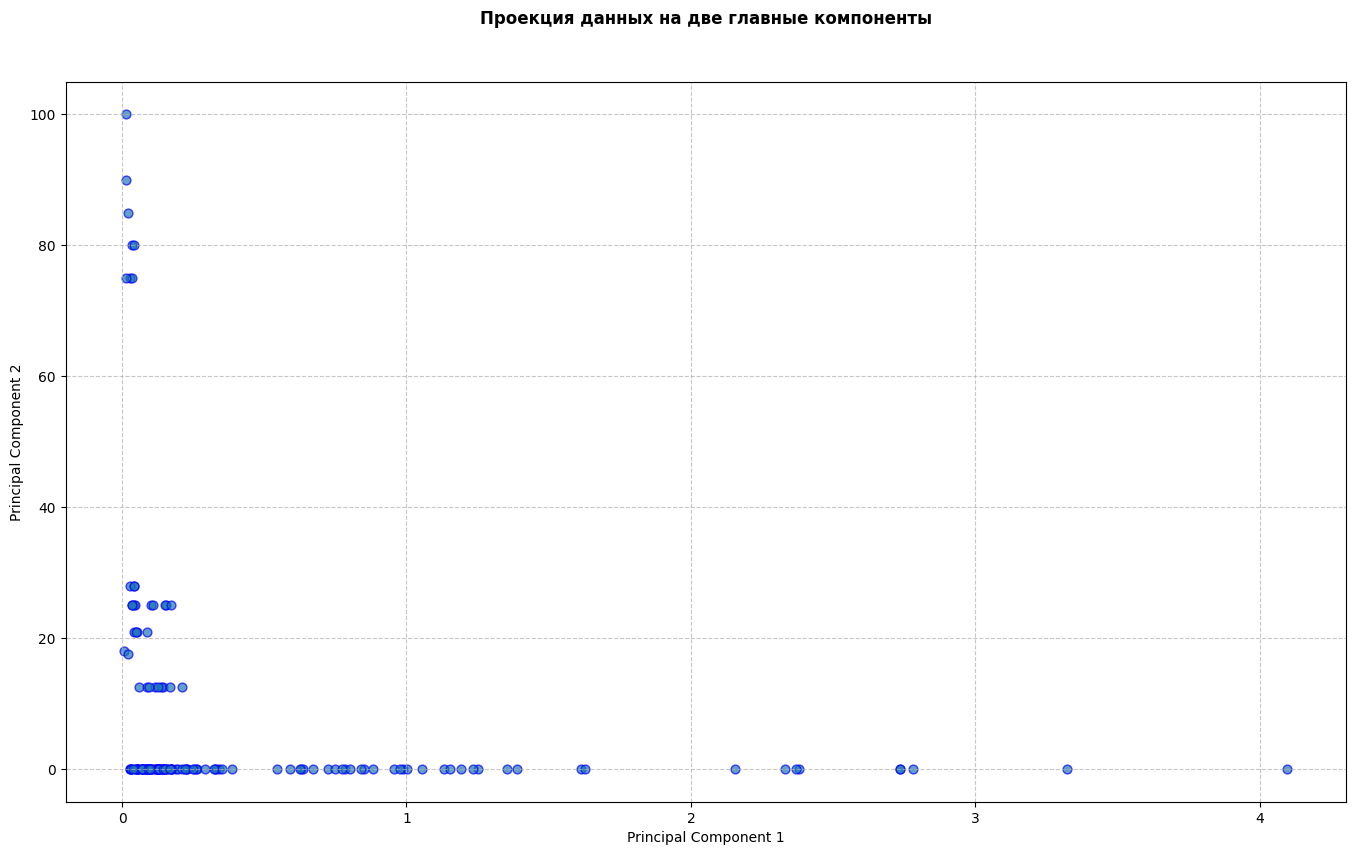

In [153]:
import pandas as pd

def apply_pca_to_dataset(dataset_name: str, k: int)-> Tuple['Matrix', float]:
  """
  Вход:
  dataset_name: название датасета
  k: число главных компонент
  Выход: кортеж (проекция данных, качество модели)
  """
  df = pd.read_csv(dataset_name)
  matrix = []
  for i in range(len(df)):
      row = []
      for j in range(0,len(df.iloc[0])):
          row.append(float(df.iloc[i].iloc[j]))
      matrix.append(row)
  matrix.append(row)

  t = Matrix(matrix,len(matrix),len(matrix[0]))
  C,e = pca(t,k)
  return C, e



C, e = apply_pca_to_dataset('/content/drive/MyDrive/BostonHousing.csv', 2)
print(C.matrix)


fig = plot_pca_projection(C)
plt.show()


[[nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [na

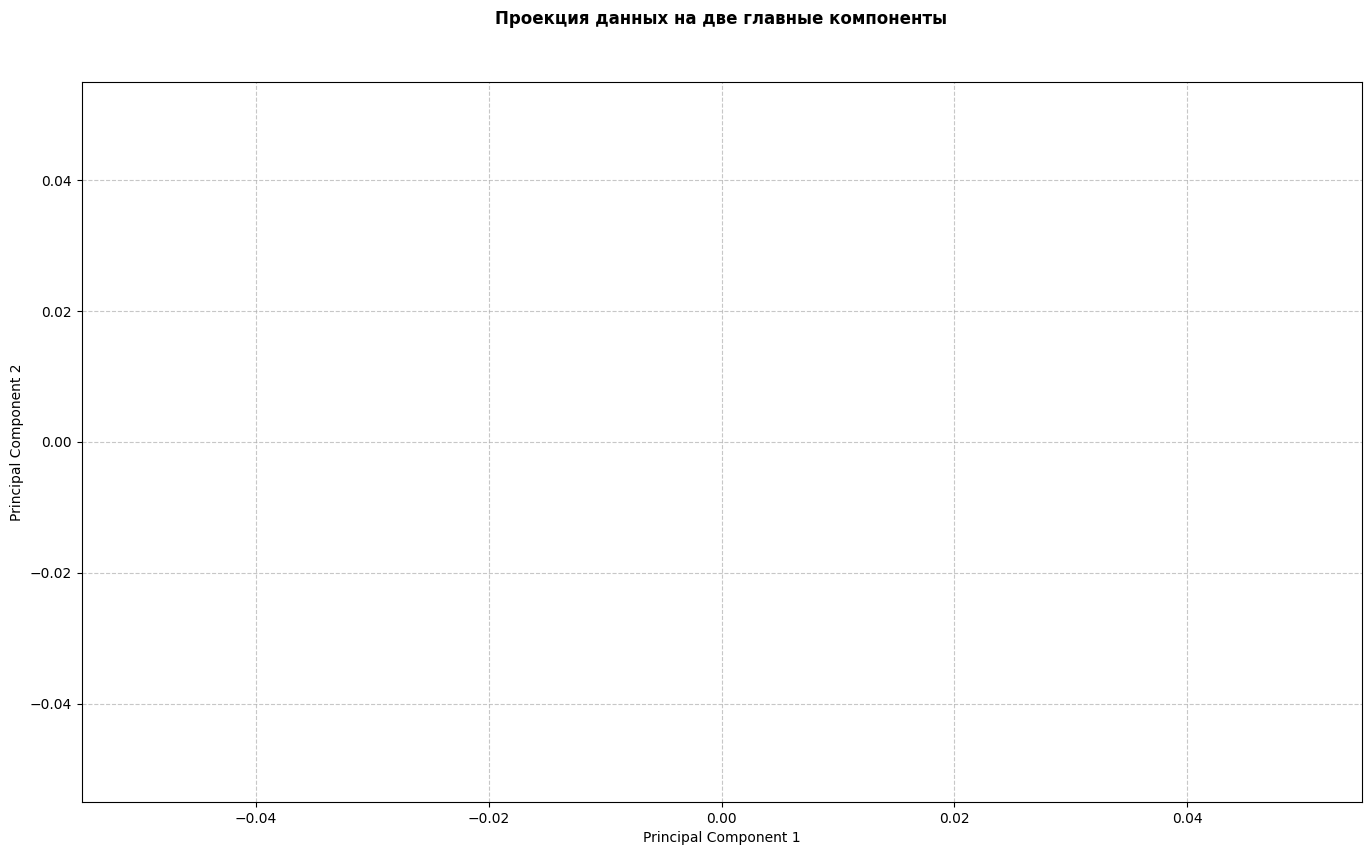

In [155]:
#Анализ примеенения РСА к данныи с шумом
#df = pd.read_csv('/content/drive/MyDrive/BostonHousing.csv')
df = pd.read_csv('/content/drive/MyDrive/BostonHousing.csv')
matrix = []
for i in range(len(df)):
    row = []
    for j in range(0,len(df.iloc[0])):
        row.append(float(df.iloc[i].iloc[j]))
    matrix.append(row)
matrix.append(row)

t = Matrix(matrix,len(matrix),len(matrix[0]))
t_noise = add_noise_and_compare(t)
C_noise,e_noise = pca(t_noise,2)

print(C_noise.matrix)


fig = plot_pca_projection(C_noise)
plt.show()
